# ML-7. Оптимизация гиперпараметров модели

## 1. Введение

Цели модуля:
* Узнать, какие есть базовые способы оптимизации гиперпараметров (GridSearchCV, RandomSearchCV);
* Узнать, какие есть продвинутые способами оптимизации (Hyperopt, Optuna);
* Научиться их настраивать и обучать модели с их использованием,  так, чтобы улучшать итоговую метрику.  
* Провести сравнение и понять преимущества и недостатки каждого из методов


## 2. Базовая оптимизация

In [1]:
# импорт библиотек
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные моделиё
from sklearn import tree # деревья решений
from sklearn import ensemble # ансамбли
from sklearn import metrics # метрики
from sklearn import preprocessing # предобработка
from sklearn.model_selection import train_test_split # сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

### Описание задачи

Продолжим решать задачу кассификации из модуля ML-3: "Предсказание категории дохода человека"

Данные, с которыми мы будем работать были извлечены из базы данных **Бюро переписи населения 1994 года** Ронни Кохави и Барри Беккером (интеллектуальный анализ данных и визуализация, Silicon Graphics). Датасет содержит информацию о людях и их доходе. В оригинальном датасете задача была регрессионной - предсказание дохода.

Мы будем использовать версию датасета, где доход участников переписи разделен на две категории: больше и меньше (либо равен) 50K $.


Данные, с которыми мы будем работать, были извлечены из базы данных Бюро переписи населения 1994 года Ронни Кохави и Барри Беккером (интеллектуальный анализ данных и визуализация, Silicon Graphics). Датасет содержит информацию о людях и их доходе. В оригинальном датасете задача была регрессионной и заключалась в предсказании дохода. Мы будем использовать версию датасета, где доход участников переписи разделен на две категории: больше и меньше (либо равен) 50 000 $.

Признаки:
* age — возраст
* workclass — сфера занятости
* fnlwgt — общий вес (число людей, которых, по мнению эксперта, представляет эта категория занятости)
* education — уровень образования
* education.num — образовательная ступень (в виде числа)
* marital.status — семейное положение
* occupation — род деятельности
* relationship — родственные отношения
* race — раса
* sex — пол
* capital.gain — ежегодный дополнительный прирост капитала
* capital.loss — ежегодная дополнительная потеря капитала
* hours.per.week — число рабочих часов в неделю
* native.country — страна рождения
* income — категория дохода (целевой признак — более 50К $ или менее 50К $)

### Знакомство с данными и их исследование

In [2]:
# ЕСЛИ РАБОТАЕМ В IDE
data = pd.read_csv('data/adult.zip')

# ЕСЛИ РАБОТАЕМ В GOOGLE COLAB
# подключаем google диск, где у нас хранятся данные
# from google.colab import drive
# drive.mount('/content/drive')
# # берем необходимый нам файл с диска, указав путь
# data = pd.read_csv('./drive/MyDrive/SF/SF module 7/adult.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Признаки:
* age - возраст
* workclass - статус занятости
* fnlwgt - общий вес, это число людей, которых, по мнению эксперта, представляет эта категория занятости
* education - образование
* education.num - образовательная ступень (в виде числа)
* marital.status - брачный статус
* occupation - профессия
* relationship - тип отношений
* race - раса
* sex - пол
* capital.gain - ежегодный дополнительный прирост капитала
* capital.loss - ежегодная дополнительная потеря капитала
* hours.per.week - число рабочих часов в неделю
* native.country - Родина 
* income - категория дохода (целевой признак)

Проверяем наличие пропусков

In [3]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [4]:
data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


Смотрим на сбалансированность классов:

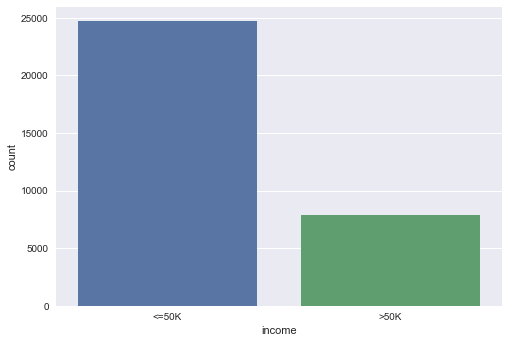

In [5]:
sns.countplot(data=data, x='income');

Для удобства переобозначим целевой признак (не обязательный шаг)

In [6]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

Исследуем категориальные признаки

In [7]:
types = data.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

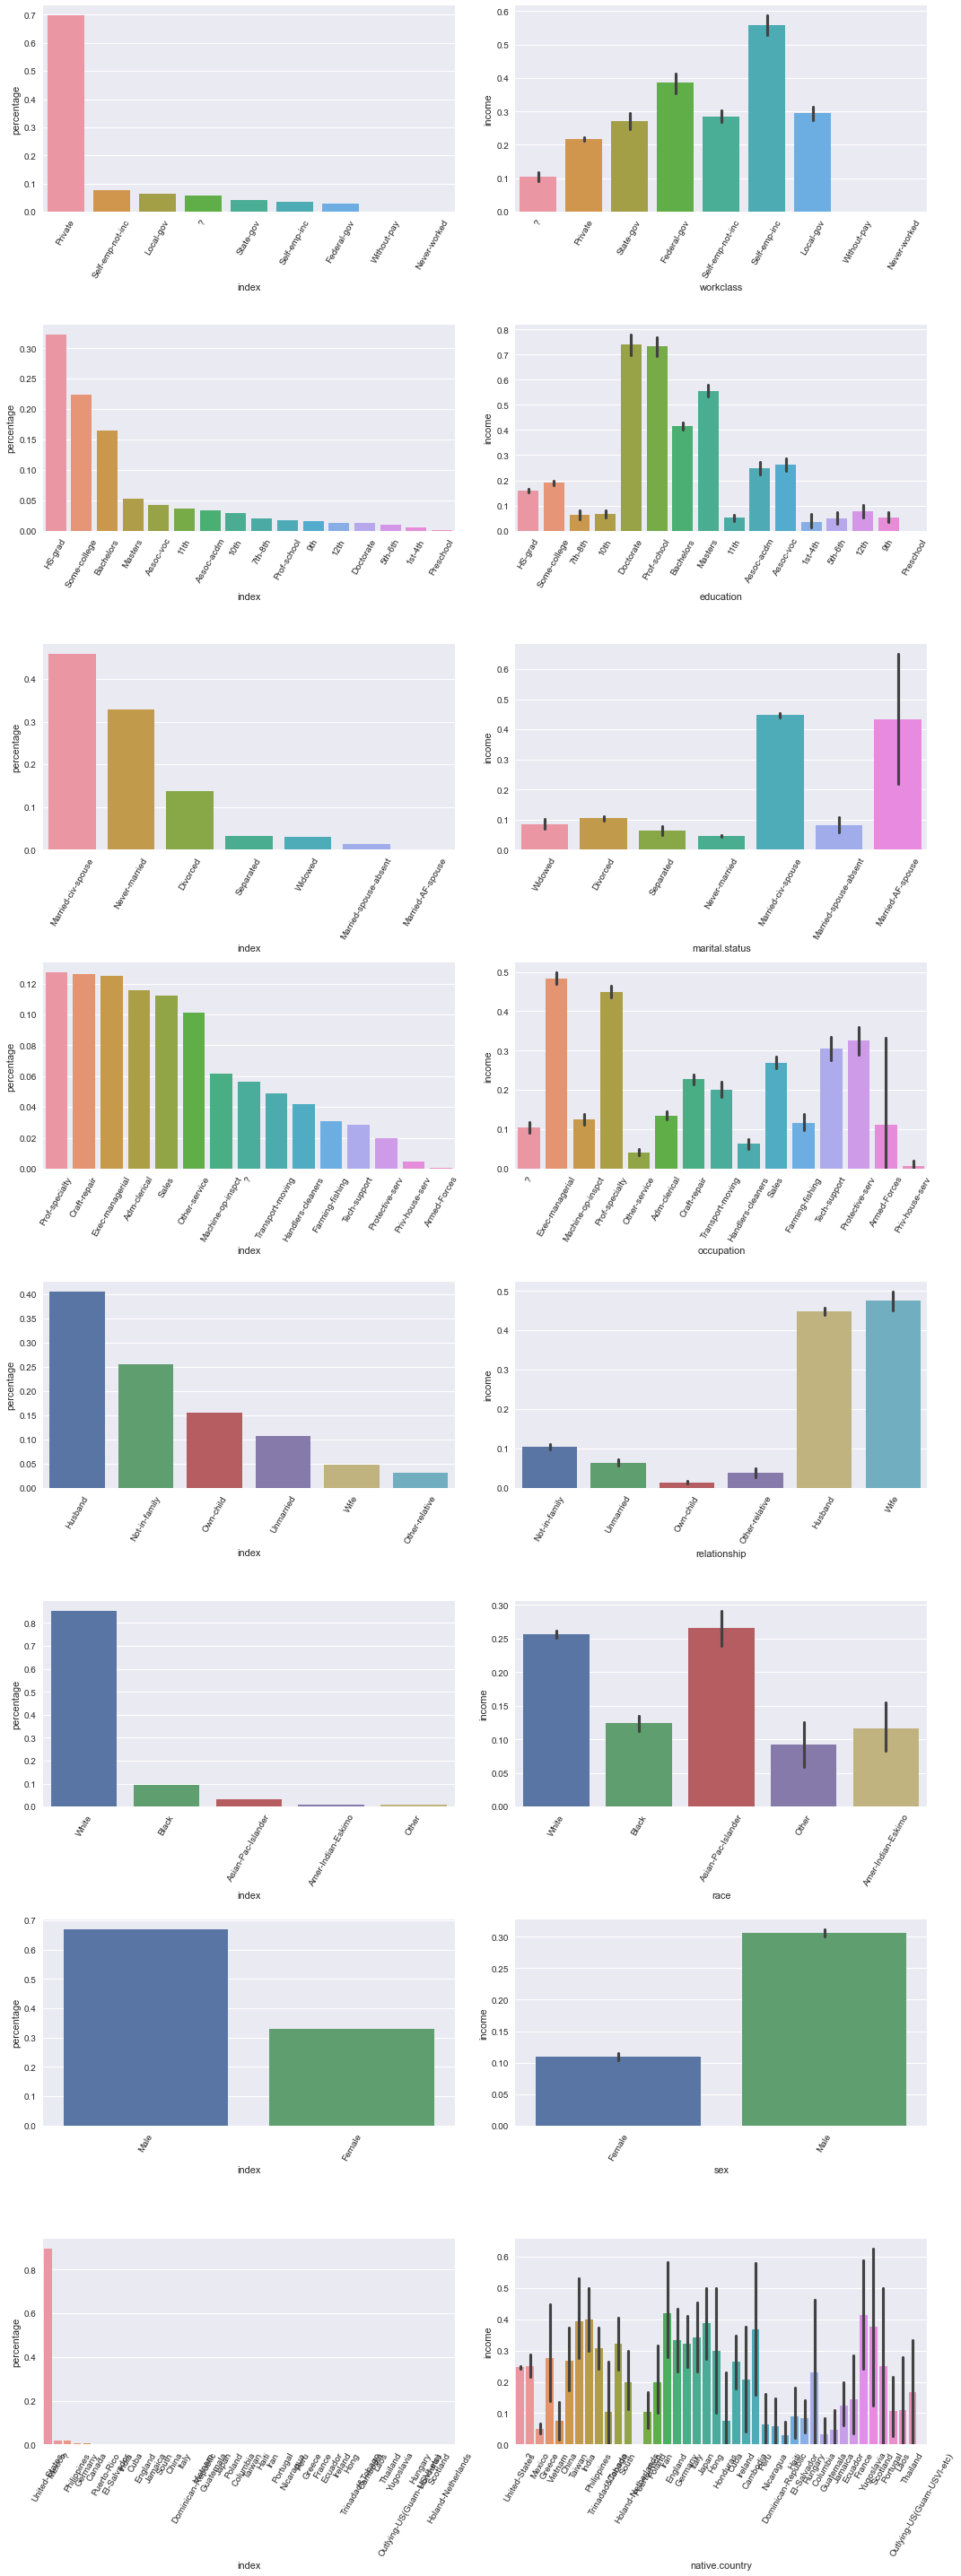

In [8]:
n = len(cat_features) # число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) # фигура+n*2 координатных плоскостей

# Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    # Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    
    # Строим столбчатую диаграмму доли людей зарабатывающих >50K 
    # (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=data, x=feature, y='income', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
    
plt.tight_layout() # выравнивание графиков

### Подготовка данных (предобработка)

Предобрабатываем категориальые признаки: уменьшаем количество категорий

In [9]:
adult_data = data.copy()

# Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)

# Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)

# Объединяем вдовцов, разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)

# Объединяем всех женатых/ за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)

# Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Whife') else 'Not in relationship'
)

# Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)

# Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

Предобрабатываем числовые признаки

In [10]:
# Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

# Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [11]:
# Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

Проверяем результаты предобработки

In [12]:
adult_data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,8,9,3,15,2,5,2,2
top,Private,HS-grad,Married,Prof-specialty,Not in relationship,White,Male,United-States
freq,22696,10501,15417,4140,19368,27816,21790,29170


Оцениваем мультиколинеарность и взаимосвязь с целевым признаком

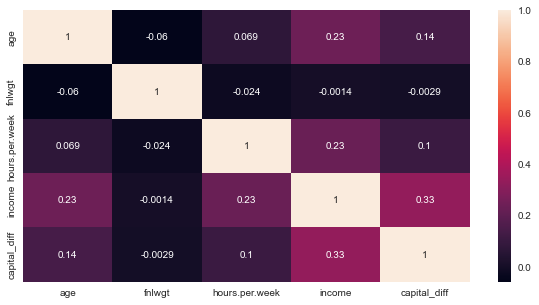

In [13]:
plt.figure(figsize = (10, 5))
sns.heatmap(adult_data.corr(), annot = True);

Кодируем текстовые категориальные признаки

In [14]:
dummies_data = pd.get_dummies(adult_data, drop_first=True)
dummies_data.head()

,age,fnlwgt,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_Local-gov,workclass_No income,workclass_Private,workclass_Self-emp-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
1,82,11.797134,18,0,8.379539,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
2,66,12.133835,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,54,11.851966,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
4,41,12.486216,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1


Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [15]:
X, y = dummies_data.drop(['income'], axis=1), dummies_data['income']

* Разделяем выборку на тренировочную и тестовую в соотношении 80/20. 
* Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

Производим нормализацию данных с помощью min-max нормализации

In [17]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Оптимизация гиперпараметров модели

#### **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [18]:
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)

# Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

accuracy_score на train наборе: 0.84
f1_score на train наборе: 0.64

accuracy_score на test наборе: 0.84
f1_score на test наборе: 0.64


### <center> **GridSearchCV**

Чтобы воспользоваться классом GridSearchCV:
- сначала необходимо импортировать библиотеку; 
- затем указать искомые гиперпараметры в виде словаря: ключами словаря являются имена настраиваемых гиперпараметров, а значениями – тестируемые настройки гиперпараметров; 
- после передаем модель (LogisticRegression), сетку искомых параметров (param_grid), а также число фолдов, которые мы хотим использовать в кросс-валидации, (допустим, пятиблочную кросс-валидацию, cv=5) и n_jobs = -1, чтобы использовать все доступные ядра для расчетов.

Созданный нами объект grid_search аналогичен классификатору, мы можем вызвать стандартные методы fit, predict и score от его имени. Однако, когда мы вызываем fit, он запускает кросс-валидацию для каждой комбинации гиперпараметров, указанных в param_grid.

GridSearchCV включает в себя не только поиск лучших параметров, но и автоматическое построение новой модели на всем обучающем наборе данных, используя параметры, которые дают наилучшее значение точности при кросс-валидации.


In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['l2', 'none'], # тип регурялизации
    'solver': ['lbfgs', 'saga'], # алгоритм оптимизации
    }

grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, # генератор случайных чисел
        max_iter=1000 # количество итераций на сходимость
    ),
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1
)

%time grid_search.fit(X_train_scaled, y_train)

y_train_pred = grid_search.predict(X_train_scaled)
y_test_pred = grid_search.predict(X_test_scaled)


print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {grid_search.best_params_}')

CPU times: total: 1.02 s
Wall time: 19.2 s
accuracy_score на train наборе: 0.84
f1_score на train наборе: 0.64

accuracy_score на test наборе: 0.84
f1_score на test наборе: 0.64

Наилучшие значения гиперпараметров: {'penalty': 'none', 'solver': 'lbfgs'}


Значения метрик не изменились, но это значит лишь, что мы не нашли комбинацию внешних параметров лучше, чем заданы по умолчанию. Это не удивительно и достаточно часто исходные  гиперпараметры дают неплохой результат, но это не повод останавливаться.

**Попробуем расширить сетку гиперпараметров.**

In [20]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, 
        max_iter=1000
    ), 
    param_grid=param_grid, 
    cv=5,
    n_jobs = -1,
    scoring='f1'
)  

%time grid_search_1.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_1.predict(X_train_scaled)
y_test_pred = grid_search_1.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {grid_search.best_params_}')

c:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


CPU times: total: 1.67 s
Wall time: 1min 8s
accuracy_score на train наборе: 0.84
f1_score на train наборе: 0.64

accuracy_score на test наборе: 0.84
f1_score на test наборе: 0.64

Наилучшие значения гиперпараметров: {'penalty': 'none', 'solver': 'lbfgs'}


### Модель перебора гиперпараметров с кросс-валидацией с применением стратификации

In [21]:
from sklearn.model_selection import StratifiedKFold

In [22]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

grid_search_2 = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, 
        max_iter=1000
    ), 
    param_grid=param_grid, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs = -1,
    scoring='f1'
)  

%time grid_search_2.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_2.predict(X_train_scaled)
y_test_pred = grid_search_2.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {grid_search_2.best_params_}')

CPU times: total: 781 ms
Wall time: 1min 11s
accuracy_score на train наборе: 0.84
f1_score на train наборе: 0.64

accuracy_score на test наборе: 0.84
f1_score на test наборе: 0.64

Наилучшие значения гиперпараметров: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


**Метрику опять не удалось улучшить, а время потратили много, в 5 раз больше!**

Поиск по сетке не гарантирует, что мы найдем наилучшую комбинацию гиперпараметров, а все потому что сетка значений конечна и фактическое наилучшее значение может отсутствовать или оказаться между значений, заданными нами.


Ознакомиться с итоговой полученной моделью можно с помощью best_estimator_. 

In [23]:
print(f'Наилучшая модель:\n{grid_search.best_estimator_}')
print()
print(f'Наилучшая модель:\n{grid_search_1.best_estimator_}')

Наилучшая модель:
LogisticRegression(max_iter=1000, penalty='none', random_state=42)

Наилучшая модель:
LogisticRegression(C=0.01, max_iter=1000, penalty='none', random_state=42)


А наилучшее значение точности кросс-валидации (значение точности, усредненное по всем разбиениям для данной комбинации гиперпараметров) – в атрибуте best_score_. 

**не путайте best_score_ со значением точности модели, которое вычисляется на тестовом наборе с помощью метода score. Метод score (оценивающий качество результатов, полученных с помощью метода predict) использует модель, построенную на всем обучающем наборе данных. В атрибуте best_score_ записывается средняя точность кросс-валидации. Для ее вычисления используется модель, построенная на обучающем наборе кросс-валидации.

In [24]:
print(f'Наилучшее значение точности при кросс-валидаци: {grid_search.best_score_:.2f}')
print()
print(f'Наилучшее значение точности при кросс-валидаци: {grid_search_1.best_score_:.2f}')

Наилучшее значение точности при кросс-валидаци: 0.84

Наилучшее значение точности при кросс-валидаци: 0.64


In [25]:
# Взглянем на результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_1.cv_results_)
result_cv.head(2)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.183454,0.083245,0.003702,0.000602,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.592664,0.590737,0.602262,0.605747,0.6,0.598282,0.00571,52
1,0.531892,0.167255,0.006201,0.001167,0.01,l2,sag,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}",0.592664,0.590737,0.602262,0.605747,0.6,0.598282,0.00571,52


In [26]:
result_cv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_penalty', 'param_solver', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [27]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
visual

param_solver,lbfgs,liblinear,sag,saga
param_C,,,,
0.01,0.619091,0.583769,0.619063,0.583803
0.10,0.636287,0.632770,0.636258,0.632611
0.30,0.639157,0.636635,0.639129,0.637701
0.50,0.639332,0.638607,0.639275,0.638802
0.70,0.639370,0.638942,0.639342,0.638935
0.90,0.639518,0.638713,0.639490,0.638913
1.00,0.639405,0.638653,0.639377,0.638862


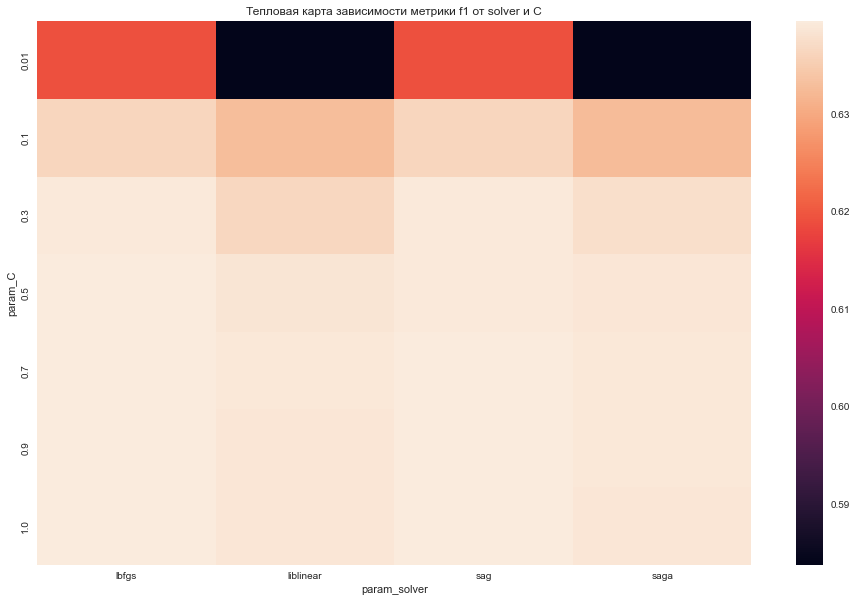

In [28]:
# отрисуем, как менялась точность при различных гиперпараметрах
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(visual, ax=ax)
ax.set_title('Тепловая карта зависимости метрики f1 от solver и С');

Видим, что слабая регуляризация С = 0,01 отрицательно влияет на метрику, поэтому есть смысл брать значения больше 0,5 и  алгоритмы оптимизации lbfgs и sag работают лучше.

### <center> **RandomizedSearchCV**

В отличие от GridSearchCV, не все комбинации гиперпараметров проверяются, а только заданное количество комбинаций выбирается из указанных распределений. Количество комбинаций гиперпараметров задается n_iter.

С использованием класса RandomizedSearchCV из библиотеки scikit learn мы осуществим оптимизацию гиперпараметров для алгоритмов логистической регрессии, дерева решений и случайного леса, а также сравним результаты с GridSearchCV и значениями по умолчанию.

In [29]:
from sklearn.model_selection import RandomizedSearchCV

#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {
    'penalty': ['l2', 'none'] ,
    'solver': ['lbfgs', 'sag'],
    'C': list(np.linspace(0.01, 1, 10, dtype=float))
}
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter=10, 
    n_jobs=-1
)
  
%time random_search.fit(X_train_scaled, y_train) 
y_train_pred = random_search.predict(X_train_scaled)
y_test_pred = random_search.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {random_search.best_params_}')

CPU times: total: 672 ms
Wall time: 25.4 s
accuracy_score на train наборе: 0.84
f1_score на train наборе: 0.64

accuracy_score на test наборе: 0.84
f1_score на test наборе: 0.64

Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.89}


За 10 итераций метрику улучшить не удалось, но обратите внимание на время. 

Давайте зададим аналогичную сетку и проделаем тоже с помощью GridSearchCV и сравним:

In [30]:
param_grid = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
              'C': list(np.linspace(0.01, 10, 10, dtype=float))},
            
grid_search_2 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1
)

%time grid_search_2.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_2.predict(X_train_scaled)
y_test_pred = grid_search_2.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {grid_search_2.best_params_}')

CPU times: total: 1.36 s
Wall time: 1min 28s
accuracy_score на train наборе: 0.84
f1_score на train наборе: 0.64

accuracy_score на test наборе: 0.84
f1_score на test наборе: 0.64

Наилучшие значения гиперпараметров: {'C': 3.34, 'penalty': 'l2', 'solver': 'lbfgs'}


#### **Дерево решений**

Проделаем аналогичное для DecisionTreeClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [31]:
# Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(random_state=42)

# Обучаем дерево по алгоритму CARTrint
dt.fit(X_train_scaled, y_train)

# Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.62


Теперь зададим сетку гиперпараметров:  
*  'min_samples_leaf' - минимальное количество объектов в листе;
*  'max_depth': максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение;
*  'criterion' - критерий информативности

И посчитаем RandomizedSearchCV() и затем GridSearchCV()





In [32]:
param_distributions = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
random_search_tree = RandomizedSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter=50, 
    n_jobs=-1
)

%time random_search_tree.fit(X_train_scaled, y_train) 
y_train_pred = random_search_tree.predict(X_train_scaled)
y_test_pred = random_search_tree.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {random_search_tree.best_params_}')

CPU times: total: 828 ms
Wall time: 4.08 s
accuracy_score на train наборе: 0.86
f1_score на train наборе: 0.67

accuracy_score на test наборе: 0.86
f1_score на test наборе: 0.66

Наилучшие значения гиперпараметров: {'min_samples_leaf': 41, 'max_depth': 15, 'criterion': 'entropy'}


In [63]:
param_grid = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
             }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1
)

%time grid_search_tree.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_tree.predict(X_train_scaled)
y_test_pred = grid_search_tree.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {grid_search_tree.best_params_}')

KeyboardInterrupt: 

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
param_grid = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
             }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1
)

%time grid_search_tree.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_tree.predict(X_train_scaled)
y_test_pred = grid_search_tree.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {grid_search_tree.best_params_}')

KeyboardInterrupt: 

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
param_grid = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
             }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1
)

%time grid_search_tree.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_tree.predict(X_train_scaled)
y_test_pred = grid_search_tree.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {grid_search_tree.best_params_}')

KeyboardInterrupt: 

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
param_grid = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
             }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1
)

%time grid_search_tree.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_tree.predict(X_train_scaled)
y_test_pred = grid_search_tree.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {grid_search_tree.best_params_}')

KeyboardInterrupt: 

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
param_grid = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
             }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1
)

%time grid_search_tree.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_tree.predict(X_train_scaled)
y_test_pred = grid_search_tree.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {grid_search_tree.best_params_}')

KeyboardInterrupt: 

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Метрику удалось улучшить  с помощью обоих методов, но RandomizedSearchCV потребовалось меньше времени;

#### **Случайный лес**

Проделаем аналогичное для RandomForestClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [64]:
# Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)
# Обучаем модель
rf.fit(X_train_scaled, y_train)

# Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.65


Теперь зададим сетку гиперпараметров: 

*   'n_estimators' - количество деревьев в лесу, по умолчанию =100

*  'min_samples_leaf' - минимальное количество объектов в листе;
*  'max_depth': максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение;




И посчитаем RandomizedSearchCV() и затем GridSearchCV()





In [65]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter=10, 
    n_jobs=-1
)  

%time random_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = random_search_forest.predict(X_train_scaled)
y_test_pred = random_search_forest.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {random_search_forest.best_params_}')

CPU times: total: 1.5 s
Wall time: 22.1 s
accuracy_score на train наборе: 0.88
f1_score на train наборе: 0.73

accuracy_score на test наборе: 0.86
f1_score на test наборе: 0.66

Наилучшие значения гиперпараметров: {'n_estimators': 80, 'min_samples_leaf': 5, 'max_depth': 33}


In [ ]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1
)  

%time grid_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_forest.predict(X_train_scaled)
y_test_pred = grid_search_forest.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {grid_search_forest.best_params_}')

Метрику удалось еще больше улучшить с помощью обоих методов, но RandomizedSearchCV опять же потребовалось в два раза меньше времени;

#### **Вывод по базовой оптимизации:**
На множестве примеров нам удалось продемонстрировать более эффективную и быструю работу RandomizedSearchCV над GridSearchCV.

### Задание 2.10
Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:
* n_estimators = от 100 до 200 с шагом 30
* min_samples_leaf = [5, 7]
* max_depth = [10, 15, 20, 25]

Используйте RandomizedSearchCV с параметрами cv = 5, n_iter = 10.

В ответе укажите метрику f1 на тестовой выборке, значение округлите до двух знаков после запятой (например, 0.58).

In [22]:
param_distributions = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5, 7],
              'max_depth': [10, 15, 20, 25]
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter=10, 
    n_jobs=-1
)  

%time random_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = random_search_forest.predict(X_train_scaled)
y_test_pred = random_search_forest.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {random_search_forest.best_params_}')

CPU times: total: 1.75 s
Wall time: 27.4 s
accuracy_score на train наборе: 0.88
f1_score на train наборе: 0.71

accuracy_score на test наборе: 0.86
f1_score на test наборе: 0.67

Наилучшие значения гиперпараметров: {'n_estimators': 100, 'min_samples_leaf': 5, 'max_depth': 20}


### Задание 2.11
Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:
* n_estimators = от 100 до 200 с шагом 30
* min_samples_leaf = [5, 7]
* max_depth = [10, 15, 20, 25]

Используйте GridSearchCV с параметрами cv = 5.

В ответе укажите метрику f1 на тестовой выборке, значение округлите до двух знаков после запятой (например, 0.58).

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5, 7],
              'max_depth': [10, 15, 20, 25]
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1
)  

%time grid_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_forest.predict(X_train_scaled)
y_test_pred = grid_search_forest.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {grid_search_forest.best_params_}')

CPU times: total: 2.12 s
Wall time: 1min 23s
accuracy_score на train наборе: 0.88
f1_score на train наборе: 0.71

accuracy_score на test наборе: 0.86
f1_score на test наборе: 0.67

Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}
